In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import tqdm
import random
import torch
from torch import nn, optim


random.seed(53113)
np.random.seed(53113)
torch.manual_seed(53113)

# 设定一些超参数
SENTENCE_LIMIT_SIZE = 20  # 句子平均长度
BATCH_SIZE = 128          # the batch size 每轮迭代1个batch的数量
LEARNING_RATE = 1e-3      # the initial learning rate 学习率
EMBEDDING_SIZE = 200      #词向量维度

In [ ]:
!git clone https://github.com/Linda230/Text_CNN.git

Cloning into 'Text_CNN'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 8 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (8/8), done.


In [ ]:
def read(filename):
    with open(filename, encoding='mac_roman') as f:
        text = f.read().lower()
        return text

pos_text, neg_text = read("Text_CNN/corpus1/pos.txt"), read("Text_CNN/corpus1/neg.txt")
total_text = pos_text +'\n'+ neg_text        #合并文本

In [ ]:
text = total_text.split()
vocab = [w for w, f in Counter(text).most_common() if f>1]
vocab = ['<pad>', '<unk>'] + vocab

token_to_word = {i:word for i, word in enumerate(vocab)}       #编码到单词
word_to_token = {word:i for i, word in token_to_word.items()}  #单词到编码

VOCAB_SIZE = len(token_to_word)                                #词汇表单词数10382

In [ ]:
def convert_text_to_token(sentence, word_to_token_map=word_to_token, limit_size=SENTENCE_LIMIT_SIZE):
    """
    根据单词-编码映射表将单个句子转化为token

    @param sentence: 句子，str类型
    @param word_to_token_map: 单词到编码的映射
    @param limit_size: 句子最大长度。超过该长度的句子进行截断，不足的句子进行pad补全

    return: 句子转换为token后的列表
    """
    # 获取unknown单词和pad的token
    unk_id = word_to_token_map["<unk>"]
    pad_id = word_to_token_map["<pad>"]

    # 对句子进行token转换，对于未在词典中出现过的词用unk的token填充
    tokens = [word_to_token_map.get(word, unk_id) for word in sentence.lower().split()]

    if len(tokens) < limit_size:                      #补齐
        tokens.extend([0] * (limit_size - len(tokens)))
    else:                                             #截断
        tokens = tokens[:limit_size]

    return tokens

In [ ]:
pos_tokens = [convert_text_to_token(sentence) for sentence in pos_text.split('\n')]
neg_tokens = [convert_text_to_token(sentence) for sentence in neg_text.split('\n')]

#为了方便处理数据，转化成numpy格式
pos_tokens = np.array(pos_tokens)
neg_tokens = np.array(neg_tokens)
total_tokens = np.concatenate((pos_tokens, neg_tokens), axis=0)                     #(10662, 20)

pos_targets = np.ones((pos_tokens.shape[0]))
neg_targets = np.zeros((neg_tokens.shape[0]))
total_targets = np.concatenate((pos_targets, neg_targets), axis=0).reshape(-1, 1)   #(10662, 1)

In [ ]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(wv_from_bin.vocab.keys()))
    return wv_from_bin

model = load_embedding_model()

[==================================================] 100.0% 252.1/252.1MB downloaded
Loaded vocab size 400000


In [ ]:
static_embeddings = np.zeros([VOCAB_SIZE, EMBEDDING_SIZE])
for word, token in tqdm.tqdm(word_to_token.items()):
    #用词向量填充
    if word in model.vocab.keys():
        static_embeddings[token, :] = model[word]
    elif word == '<pad>':                                                           #如果是空白，用零向量填充
        static_embeddings[token, :] = np.zeros(EMBEDDING_SIZE)
    else:                                                                           #如果没有对应的词向量，则用随机数填充
        static_embeddings[token, :] = 0.2 * np.random.random(EMBEDDING_SIZE) - 0.1

print(static_embeddings.shape)                  #(10382, 200) 即(vocab_size,embedding_dim)

100%|██████████| 10382/10382 [00:00<00:00, 194323.89it/s]

(10382, 200)


In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(total_tokens, total_targets, test_size=0.2)     #会打乱顺序的
print(X_train.shape, y_train.shape)               #(8529, 20) (8529, 1)

(8529, 20) (8529, 1)


In [ ]:
def get_batch(x, y, batch_size=BATCH_SIZE, shuffle=True):
    assert x.shape[0] == y.shape[0], print("error shape!")

    if shuffle:
        shuffled_index = np.random.permutation(range(x.shape[0]))
        x = x[shuffled_index]
        y = y[shuffled_index]

    n_batches = int(x.shape[0] / batch_size)      #统计共几个完整的batch

    for i in range(n_batches - 1):
        x_batch = x[i*batch_size: (i+1)*batch_size]
        y_batch = y[i*batch_size: (i+1)*batch_size]

        yield x_batch, y_batch

In [ ]:
class TextCNN(nn.Module):   #output_size为输出类别（2个类别，0和1）,三种kernel，size分别是3,4，5，每种kernel有100个
    def __init__(self, vocab_size, embedding_dim, output_size, filter_num=100, kernel_lst=(3,4,5), dropout=0.5):
        super(TextCNN, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
                             nn.Sequential(nn.Conv2d(1, filter_num, (kernel, embedding_dim)),        #1表示channel_num，filter_num即输出数据通道数，卷积核大小为(kernel, embedding_dim)
                                            nn.ReLU(),
                                            nn.MaxPool2d((SENTENCE_LIMIT_SIZE - kernel + 1, 1)))
                              for kernel in kernel_lst])
        self.fc = nn.Linear(filter_num * len(kernel_lst), output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)       #[128, 20, 200](batch, seq_len, embedding_dim)
        x = x.unsqueeze(1)          #[128, 1, 20, 200] 即(batch, channel_num, seq_len, embedding_dim)
        out = [conv(x) for conv in self.convs]

        out = torch.cat(out, dim=1)      #[128, 300, 1, 1]
        out = out.view(x.size(0), -1)    #[128, 300]
        out = self.dropout(out)
        logit = self.fc(out)             #[128, 2]
        return logit

In [ ]:
cnn = TextCNN(VOCAB_SIZE, 200, 2)                          
cnn.embedding.weight.data.copy_(torch.FloatTensor(static_embeddings))

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0761, -0.0494,  0.0746,  ..., -0.0402, -0.0896, -0.0726],
        [ 0.1229,  0.5804, -0.0696,  ..., -0.0392, -0.1624, -0.0967],
        ...,
        [ 0.1924,  0.5167, -0.8184,  ...,  0.3870,  0.2092,  0.2411],
        [-0.1942, -0.4560,  0.5054,  ..., -0.8122,  0.2348, -0.0557],
        [-0.0625,  0.1861,  0.1087,  ..., -0.5705, -0.7907,  0.2285]])

In [ ]:
print(cnn)

TextCNN(
  (embedding): Embedding(10382, 200)
  (convs): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 100, kernel_size=(3, 200), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(18, 1), stride=(18, 1), padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(1, 100, kernel_size=(4, 200), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(17, 1), stride=(17, 1), padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(1, 100, kernel_size=(5, 200), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(16, 1), stride=(16, 1), padding=0, dilation=1, ceil_mode=False)
    )
  )
  (fc): Linear(in_features=300, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
optimizer = optim.Adam(cnn.parameters(), lr=LEARNING_RATE)
criteon = nn.CrossEntropyLoss()

In [ ]:
def binary_acc(preds, y):
     correct = torch.eq(preds, y).float()
     acc = correct.sum() / len(correct)
     return acc    

In [ ]:
def train(cnn, optimizer, criteon):

    avg_loss = []
    avg_acc = []
    cnn.train()        #表示进入训练模式


    for x_batch, y_batch in get_batch(X_train, y_train):   #遍历每一个batch，x_batch.shape=(128, 20)  y_batch.shape=(128, 1)
        x_batch = torch.LongTensor(x_batch)                #要先转成Tensor类型，否则计算交叉熵时会报错
        y_batch = torch.LongTensor(y_batch)

        y_batch = y_batch.squeeze()      #torch.Size([128])
        pred = cnn(x_batch)              #torch.Size([128, 2])

        #torch.max(pred, dim=1)[1]得到每一行概率值较大的索引
        acc = binary_acc(torch.max(pred, dim=1)[1], y_batch)   #计算每个batch的准确率
        avg_acc.append(acc)

        loss = criteon(pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_acc = np.array(avg_acc).mean()
    return avg_acc

In [ ]:
def evaluate(cnn, criteon):
    avg_acc = []
    cnn.eval()         #表示进入测试模式

    with torch.no_grad():
        for x_batch, y_batch in get_batch(X_test, y_test):
            x_batch = torch.LongTensor(x_batch)
            y_batch = torch.LongTensor(y_batch)

            y_batch = y_batch.squeeze()       #torch.Size([128])
            pred = cnn(x_batch)               #torch.Size([128, 2])

            acc = binary_acc(torch.max(pred, dim=1)[1], y_batch)
            avg_acc.append(acc)

    avg_acc = np.array(avg_acc).mean()
    return avg_acc

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch=0,训练准确率=0.6668269038200378
epoch=0,测试准确率=0.7354166507720947
epoch=1,训练准确率=0.7896634340286255
epoch=1,测试准确率=0.7630208134651184
epoch=2,训练准确率=0.8443509340286255
epoch=2,测试准确率=0.7645833492279053
epoch=3,训练准确率=0.9007211327552795
epoch=3,测试准确率=0.7713541388511658
epoch=4,训练准确率=0.9359375238418579
epoch=4,测试准确率=0.7755208611488342
epoch=5,训练准确率=0.9599759578704834
epoch=5,测试准确率=0.7744791507720947
epoch=6,训练准确率=0.9825721383094788
epoch=6,测试准确率=0.7651041746139526
epoch=7,训练准确率=0.989062488079071
epoch=7,测试准确率=0.7651041746139526
epoch=8,训练准确率=0.9947115182876587
epoch=8,测试准确率=0.7635416388511658
epoch=9,训练准确率=0.9967548251152039
epoch=9,测试准确率=0.7635416388511658
epoch=10,训练准确率=0.9975961446762085
epoch=10,测试准确率=0.7588541507720947
epoch=11,训练准确率=0.9986779093742371
epoch=11,测试准确率=0.7666666507720947
epoch=12,训练准确率=0.998317301273346
epoch=12,测试准确率=0.7515624761581421
epoch=13,训练准确率=0.9989182949066162
epoch=13,测试准确率=0.7583333253860474
epoch=14,训练准确率=0.9993990659713745
epoch=14,测试准确率=0.7536458373069763
ep

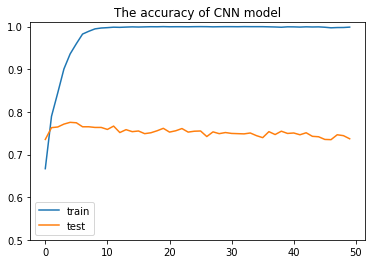

In [ ]:
cnn_train_acc, cnn_test_acc = [], []

for epoch in range(50):

    train_acc = train(cnn, optimizer, criteon)
    print('epoch={},训练准确率={}'.format(epoch, train_acc))
    test_acc = evaluate(cnn, criteon)
    print("epoch={},测试准确率={}".format(epoch, test_acc))
    cnn_train_acc.append(train_acc)
    cnn_test_acc.append(test_acc)

plt.plot(cnn_train_acc)
plt.plot(cnn_test_acc)
plt.ylim(ymin=0.5, ymax=1.01)
plt.title("The accuracy of CNN model")
plt.legend(["train", "test"])

In [7]:
!git clone https://github.com/Linda230/Text_CNN.git

Cloning into 'Text_CNN'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 8 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (8/8), done.


.vector_cache/glove.6B.zip: 0.00B [00:00, ?B/s]

len of train data: 8530
len of test data: 2132
['if', 'you', 'go', 'into', 'the', 'theater', 'expecting', 'a', 'scary', ',', 'action', '-', 'packed', 'chiller', ',', 'you', 'might', 'soon', 'be', 'looking', 'for', 'a', 'sign', '.', 'an', 'exit', 'sign', ',', 'that', 'is']
0


.vector_cache/glove.6B.zip: 862MB [02:41, 5.35MB/s]                           
100%|█████████▉| 399486/400000 [00:28<00:00, 13638.47it/s]

10002
['<unk>', '<pad>', 'the', ',', 'a', 'and', 'of', 'to', '.', '-', "'s", 'is']
32
defaultdict(None, {0: 0, 1: 1})
torch.Size([128, 20])
torch.Size([128])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|█████████▉| 399486/400000 [00:40<00:00, 13638.47it/s]

epoch=0,训练准确率=0.6460826396942139
epoch=0,测试准确率=0.7059042453765869
epoch=1,训练准确率=0.7266393303871155
epoch=1,测试准确率=0.7219887971878052
epoch=2,训练准确率=0.7513509392738342
epoch=2,测试准确率=0.7077205777168274
epoch=3,训练准确率=0.7569109797477722
epoch=3,测试准确率=0.7058823704719543
epoch=4,训练准确率=0.7560093998908997
epoch=4,测试准确率=0.7109375
epoch=5,训练准确率=0.763887345790863
epoch=5,测试准确率=0.7157956957817078
epoch=6,训练准确率=0.770431399345398
epoch=6,测试准确率=0.7157519459724426
epoch=7,训练准确率=0.7661027908325195
epoch=7,测试准确率=0.7171743512153625
epoch=8,训练准确率=0.7803711891174316
epoch=8,测试准确率=0.7183123230934143
epoch=9,训练准确率=0.77639240026474
epoch=9,测试准确率=0.7180934548377991
epoch=10,训练准确率=0.778002142906189
epoch=10,测试准确率=0.7203912734985352
epoch=11,训练准确率=0.7791966199874878
epoch=11,测试准确率=0.7199317216873169
epoch=12,训练准确率=0.7759487628936768
epoch=12,测试准确率=0.7148547172546387
epoch=13,训练准确率=0.7860848307609558
epoch=13,测试准确率=0.7134541273117065
epoch=14,训练准确率=0.7866905927658081
epoch=14,测试准确率=0.7067795991897583
epoch=15,训练准确率

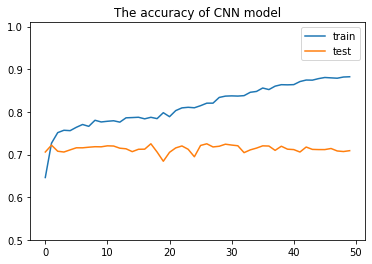

In [9]:
import numpy as np
import torch
from torch import nn, optim
from torchtext.legacy.data import *
import matplotlib.pyplot as plt

import random

SEED = 123
BATCH_SIZE = 128
LEARNING_RATE = 1e-3      #学习率
EMBEDDING_SIZE = 200      #词向量维度
SENTENCE_LIMIT_SIZE = 20  #句子平均长度

torch.manual_seed(SEED)

TEXT = Field(tokenize='spacy', lower=True, fix_length=20, batch_first=True)       #以空格分开，小写，fix_length指定了每条文本的长度，截断补长
LABEL = LabelField(dtype=torch.float)

#get_dataset构造并返回Dataset所需的examples和fields
def get_dataset(corpus_path, text_field, label_field, datatype):
    fields = [('text', text_field), ('label', label_field)]             #torchtext文件配对关系
    examples = []

    with open(corpus_path, encoding='mac_roman') as f:

        content = f.readline().replace('\n', '')
        while content:
            if datatype == 'pos':
                label = 1
            else:
                label = 0
            examples.append(Example.fromlist([content[:-2], label], fields))
            content = f.readline().replace('\n', '')

    return examples, fields


#得到构建Dataset所需的examples和fields
pos_examples, pos_fields = get_dataset("Text_CNN/corpus1/pos.txt", TEXT, LABEL, 'pos')
neg_examples, neg_fields = get_dataset("Text_CNN/corpus1/neg.txt", TEXT, LABEL, 'neg')
all_examples, all_fields = pos_examples+neg_examples, pos_fields+neg_fields


#构建Dataset数据集
total_data = Dataset(all_examples, all_fields)

#分割训练集和测试集
train_data, test_data = total_data.split(random_state=random.seed(SEED), split_ratio=0.8)

print('len of train data:', len(train_data))            #8530
print('len of test data:', len(test_data))              #2132

print(train_data.examples[15].text)
print(train_data.examples[15].label)
#['if', 'you', 'go', 'into', 'the', 'theater', 'expecting', 'a', 'scary', ',', 'action-packed', 'chiller', ',', 'you', 'might', 'soon', 'be', 'looking', 'for', 'a', 'sign', '.', 'an', 'exit', 'sign', ',', 'that', 'is']
#0


#创建vocabulary，把每个单词一一映射到一个数字
TEXT.build_vocab(train_data, max_size=10000, vectors='glove.6B.200d')
LABEL.build_vocab(train_data)
print(len(TEXT.vocab))                     #10002
print(TEXT.vocab.itos[:12])                #['<unk>', '<pad>', 'the', ',', 'a', 'and', 'of', 'to', '.', 'is', 'in', 'that']
print(TEXT.vocab.stoi['like'])             #32
print(LABEL.vocab.stoi)                    #defaultdict(None, {0: 0, 1: 1})

#创建iterator
train_iterator, test_iterator = BucketIterator.splits(
    (train_data, test_data),
    batch_size=BATCH_SIZE,
    sort = False)

print(next(iter(train_iterator)).text.shape)     #torch.Size([128, 20])如果第17行不加batch_first=True，默认False，这边会显示[20, 128]
print(next(iter(train_iterator)).label.shape)    #torch.Size([128])



class TextCNN(nn.Module):   #output_size为输出类别（2个类别，0和1）,三种kernel，size分别是3,4，5，每种kernel有100个
    def __init__(self, vocab_size, embedding_dim, output_size, filter_num=100, kernel_lst=(3,4,5), dropout=0.5):
        super(TextCNN, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
                             nn.Sequential(nn.Conv2d(1, filter_num, (kernel, embedding_dim)),
                                            nn.ReLU(),
                                            nn.MaxPool2d((SENTENCE_LIMIT_SIZE - kernel + 1, 1)))
                              for kernel in kernel_lst])
        self.fc = nn.Linear(filter_num * len(kernel_lst), output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)       #(batch, word_num, embedding_dim)
        x = x.unsqueeze(1)          #[128, 1, 20, 200] 即(batch, channel_num, word_num, embedding_dim)
        out = [conv(x) for conv in self.convs]

        out = torch.cat(out, dim=1)      # [128, 300, 1, 1]
        out = out.view(x.size(0), -1)    #[128, 300]
        out = self.dropout(out)
        logit = self.fc(out)             #[128, 2]

        return logit


PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

#使用预训练过的embedding来替换随机初始化
cnn = TextCNN(len(TEXT.vocab), 200, 2)

pretrained_embedding = TEXT.vocab.vectors                          #torch.Size([10002, 200])
cnn.embedding.weight.data.copy_(pretrained_embedding)
cnn.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_SIZE)
cnn.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_SIZE)


optimizer = optim.Adam(cnn.parameters(), lr=LEARNING_RATE, weight_decay = 0.01)
criteon = nn.CrossEntropyLoss()


#计算准确率
def binary_acc(preds, y):

    correct = torch.eq(preds, y).float()
    acc = correct.sum() / len(correct)
    return acc


#训练函数
def train(cnn, iterator, optimizer, criteon):
    avg_acc = []
    cnn.train()        #表示进入训练模式

    for i, batch in enumerate(iterator):
        pred = cnn(batch.text)                         #torch.Size([128, 2])
        loss = criteon(pred, batch.label.long())       #不加.long()会报错

        #torch.max(pred, dim=1)[1]得到每一行概率值较大的索引
        acc = binary_acc(torch.max(pred, dim=1)[1], batch.label)   #计算每个batch的准确率
        avg_acc.append(acc)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_acc = np.array(avg_acc).mean()
    return avg_acc



#评估函数
def evaluate(cnn, iterator, criteon):
    avg_acc = []
    cnn.eval()         #表示进入测试模式

    with torch.no_grad():
        for i, batch in enumerate(iterator):
            pred = cnn(batch.text)               #torch.Size([128, 2])
            acc = binary_acc(torch.max(pred, dim=1)[1], batch.label)
            avg_acc.append(acc)

    avg_acc = np.array(avg_acc).mean()
    return avg_acc



cnn_train_acc, cnn_test_acc = [], []

for epoch in range(50):

    train_acc = train(cnn, train_iterator, optimizer, criteon)
    print('epoch={},训练准确率={}'.format(epoch, train_acc))

    test_acc = evaluate(cnn, test_iterator, criteon)
    print("epoch={},测试准确率={}".format(epoch, test_acc))

    cnn_train_acc.append(train_acc)
    cnn_test_acc.append(test_acc)

plt.plot(cnn_train_acc)
plt.plot(cnn_test_acc)
plt.ylim(ymin=0.5, ymax=1.01)
plt.title("The accuracy of CNN model")
plt.legend(["train", "test"])